# Imports

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft, ifftshift, ifft, fft2

# Function Definitions

In [11]:
def comb(x):
    x = np.round(x * 10**6) / 10**6
    out = (np.remainder(x, 1) == 0).astype(int)
    return out

def rect(t, T=1.0, t0=0.0):
    return np.where(np.abs(t-t0) <= T/2, 1,0)

def rect2D(X, Y, wx, wy, amplitude=1):
    """
    Creates a 2D rect function, intended to represent the transmittance function of a square aperture.

    Parameters:
    x         : x-axis of created mesh grid
    y         : y-axis of created mesh grid
    wx        : full-width of aperture in x direction in meters
    wy        : full-width of aperture in y idrection in meters
    amplitude : amplitude of transmittance function, defaults to 1.
    """
    # xx, yy = np.meshgrid(x, y)
    mask_x = np.abs(X) <= wx / 2
    mask_y = np.abs(Y) <= wy / 2
    unit_plane = amplitude * (mask_x & mask_y)
    return unit_plane

def circ(X, Y, r=1.0, amplitude=1.0, x0=0.0, y0=0.0):
    """
    Creates a circ function, intended to represent the transmittance function of a circular aperture.

    Parameters:
    x         : x-axis of created mesh grid
    y         : y-axis of created mesh grid
    r         : radius of circular aperture
    amplitude : amplitude of transmittance function, defaults to 1.
    x0        : offset in x direction
    y0        : offset in y direction
    """
    distance = np.sqrt((X - x0) ** 2 + (Y - y0) ** 2)
    circle_mask = distance <= r
    return amplitude * circle_mask

def Fraunhoffer_propagation(u1, L1, lam, z):
    M = np.shape(u1)[0] # assumes coordinate system of input wave is square
    dx1 = L1 / M
    k = 2 * np.pi / lam

    L2 = lam * z / dx1  # side length in obs plane
    dx2 = lam * z / L1  # sample interval in obs plane
    x2 = np.linspace(-L2 / 2, L2 / 2, M)

    X2, Y2 = np.meshgrid(x2, x2)

    c = 1 / (1j * lam * z) * np.exp(1j * k / (2 * z) * (X2**2 + Y2**2))
    u2 = c * ifftshift(fft2(fftshift(u1))) * dx1**2

    return u2, L2

# Constants/Coordinate System Definitions

In [12]:
lam = 532e-9

Lx = 15.36e-3 # Viewing window length
Ly = Lx # Easier math in square window 
dx = 4e-6 
dy = dx
Nx = int(Lx / dx) # Total number of samples in x direction
Ny = Nx

x = np.linspace(-Lx / 2, Lx / 2 - dx, Nx)
X, Y = np.meshgrid(x, x)

# "SLM" Tranmission Function

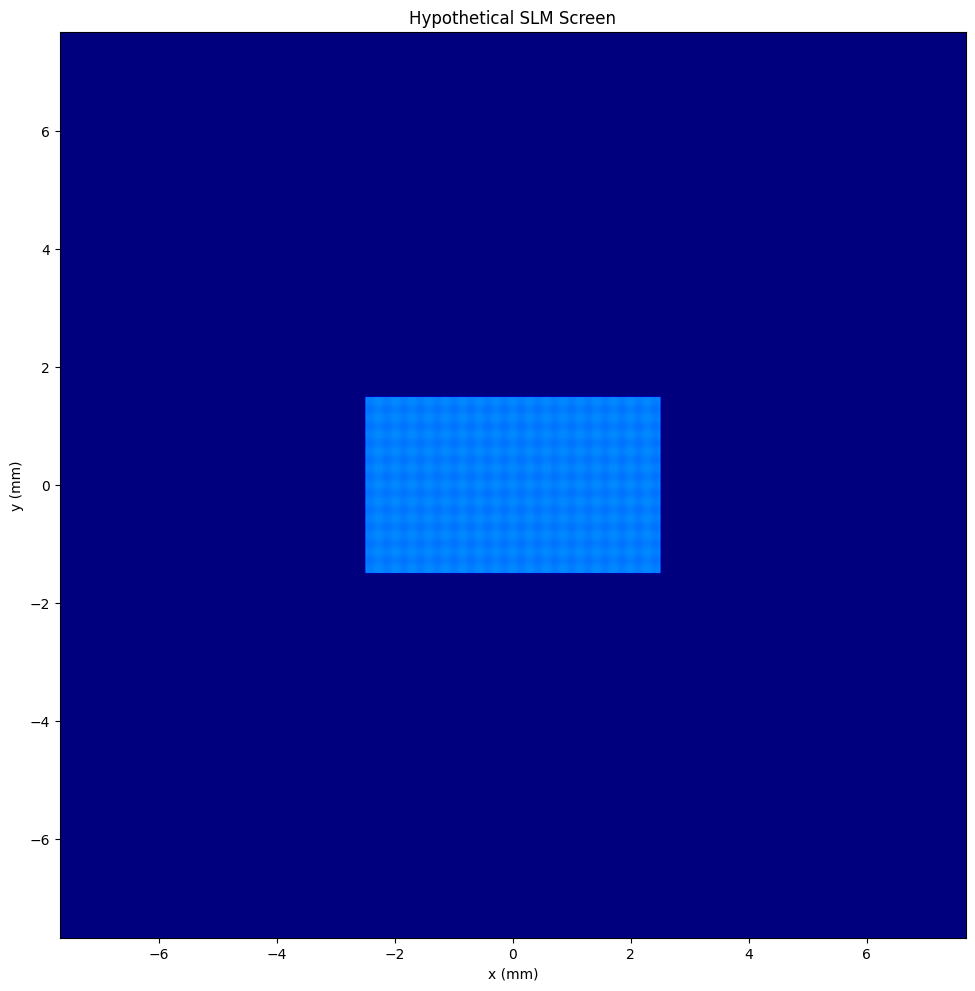

In [13]:
wx = 5e-3
wy = 3e-3
aperture = rect2D(X, Y, wx, wy)

P = 2 * 8e-6  # grating period
fc = fft(fftshift(comb(x / P)))
fr = fft(fftshift(rect(x / (P / 2))))
ux = ifftshift(ifft(fc * fr))  # 1D convolution of rect and comb
u_grating = np.tile(ux, (Nx, 1)) # this and line below create 2D grid
u_grating = u_grating * u_grating.T
u_grating = u_grating * aperture # Removes field beyond aperture stop 
u1 = u_grating
I1 = np.abs(u1**2)

plt.figure()
Lx_mm = Lx * 1e3
plt.imshow(I1, cmap="jet", extent=(-Lx_mm / 2, Lx_mm / 2, -Lx_mm / 2, Lx_mm / 2))
plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams['figure.dpi'] = 100
plt.title("Hypothetical SLM Screen")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

# Propagation through Lens

Text(0, 0.5, 'y (mm)')

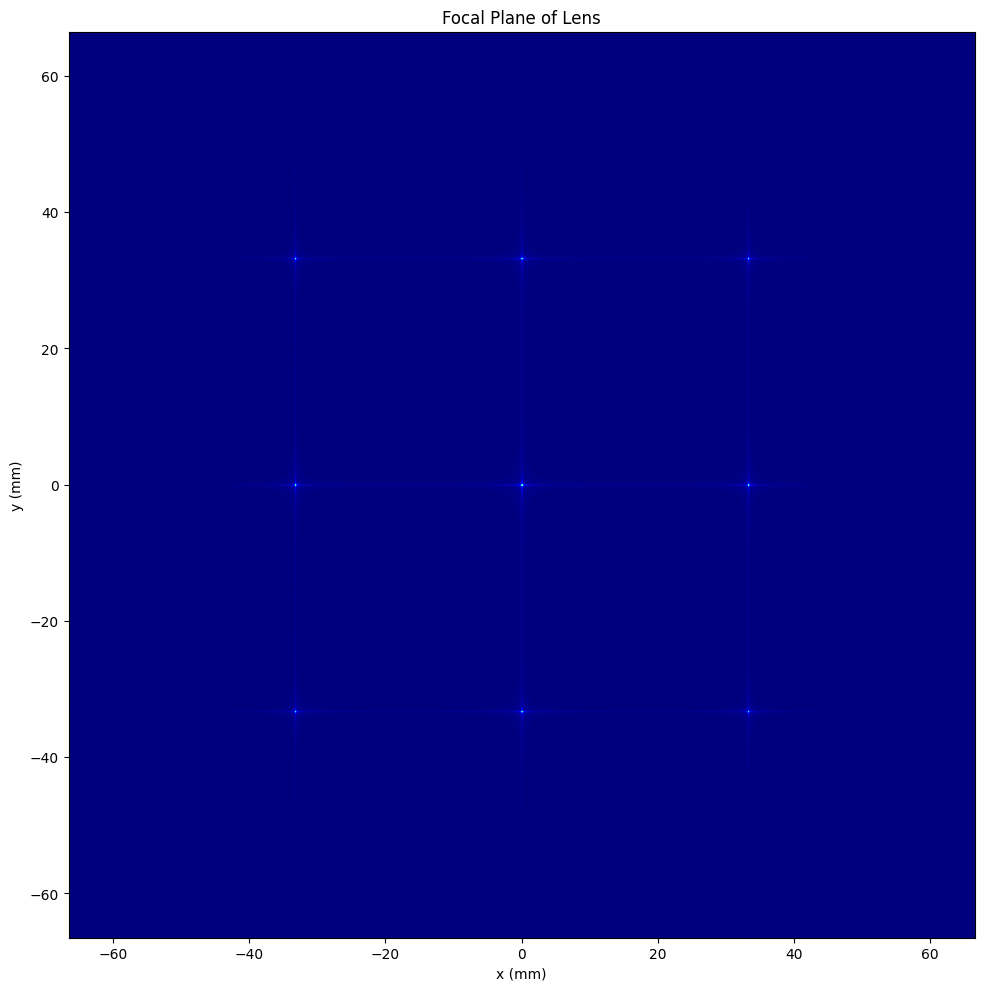

In [14]:
f = 1
u2, L2x = Fraunhoffer_propagation(u1, Lx, lam, f)
I2 = np.abs((u2) ** 2)
plt.figure()
L2x_mm = L2x * 1e3
plt.imshow(
    np.cbrt(I2), cmap="jet", extent=(-L2x_mm / 2, L2x_mm / 2, -L2x_mm / 2, L2x_mm / 2)
)
plt.title("Focal Plane of Lens")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")


# Spatial Filtering

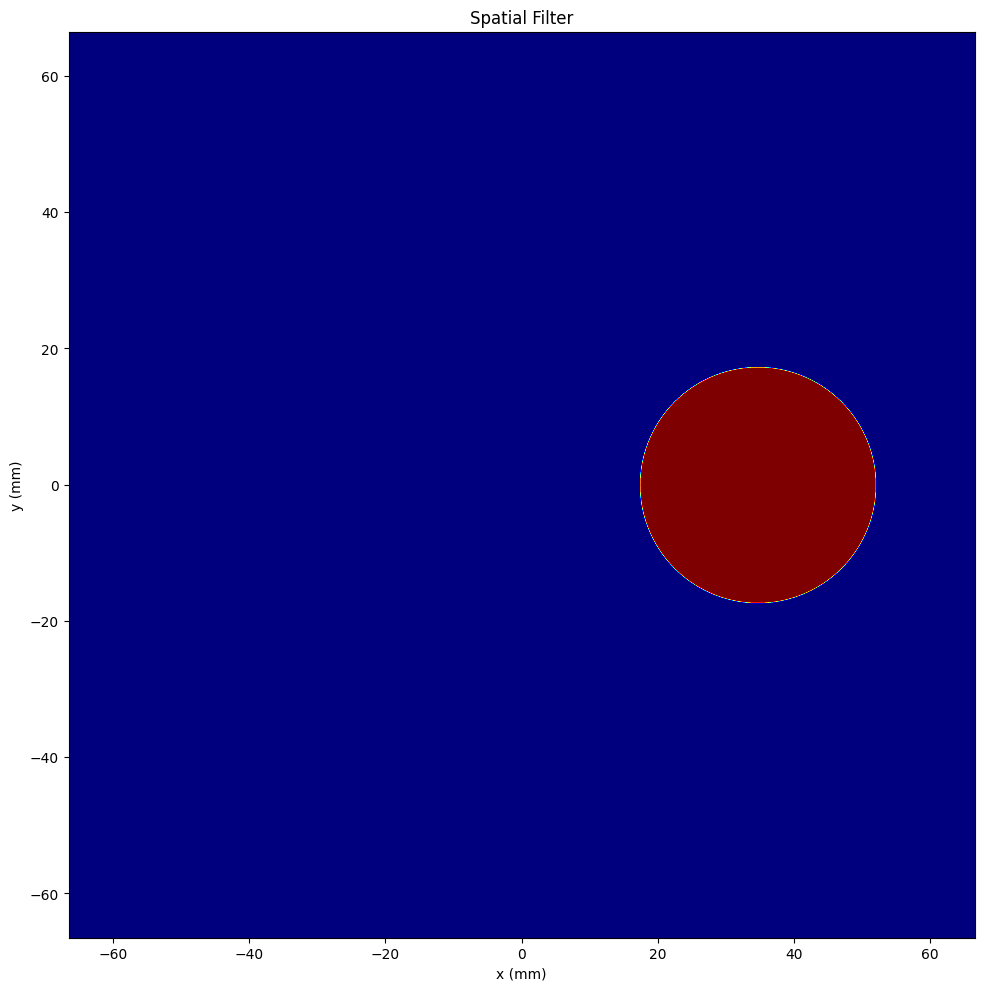

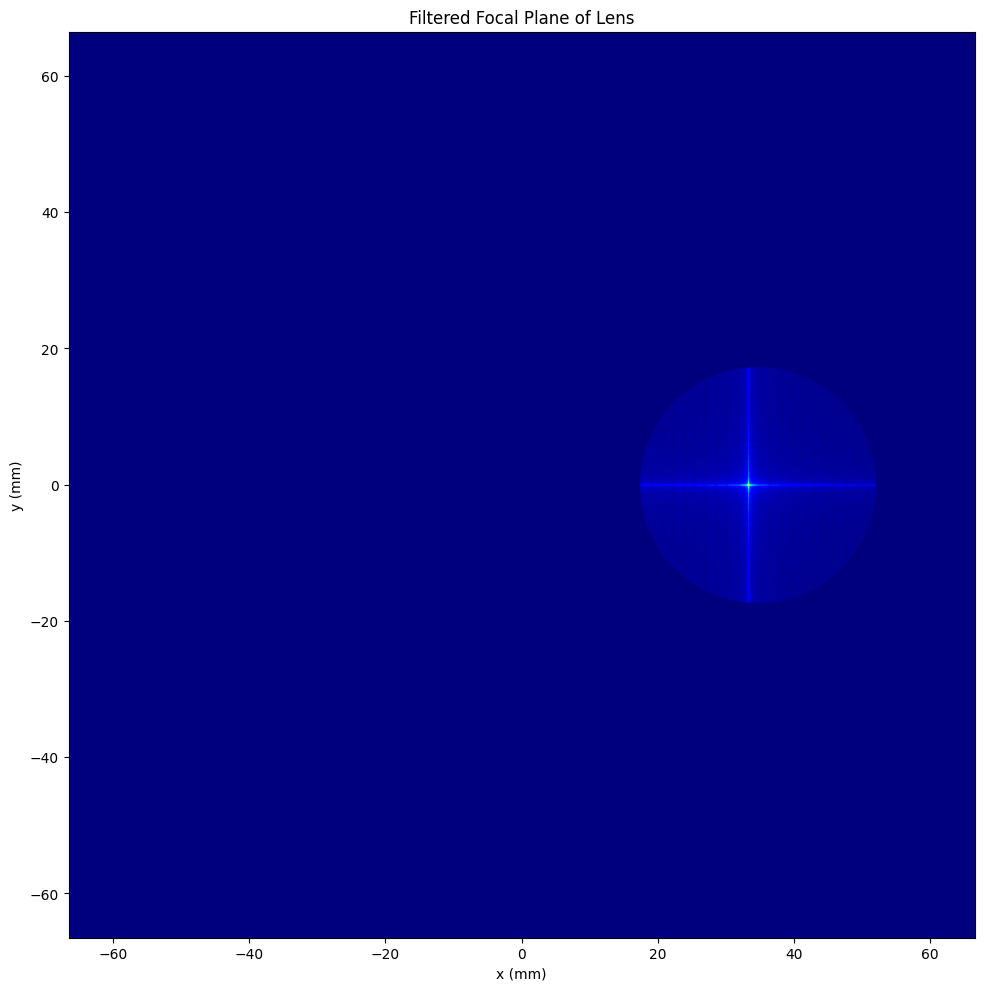

In [15]:
iris = circ(X, Y, r=2e-3, x0=4e-3)

plt.figure()
plt.imshow(iris, cmap="jet", extent=(-L2x_mm / 2, L2x_mm / 2, -L2x_mm / 2, L2x_mm / 2))
plt.title("Spatial Filter")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

filtered_u2 = u2 * iris
filtered_I2 = np.abs(filtered_u2)
plt.figure()
plt.imshow(np.cbrt(filtered_I2), cmap="jet", extent=(-L2x_mm / 2, L2x_mm / 2, -L2x_mm / 2, L2x_mm / 2))
plt.title("Filtered Focal Plane of Lens")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

# Propagation Through Second Lens

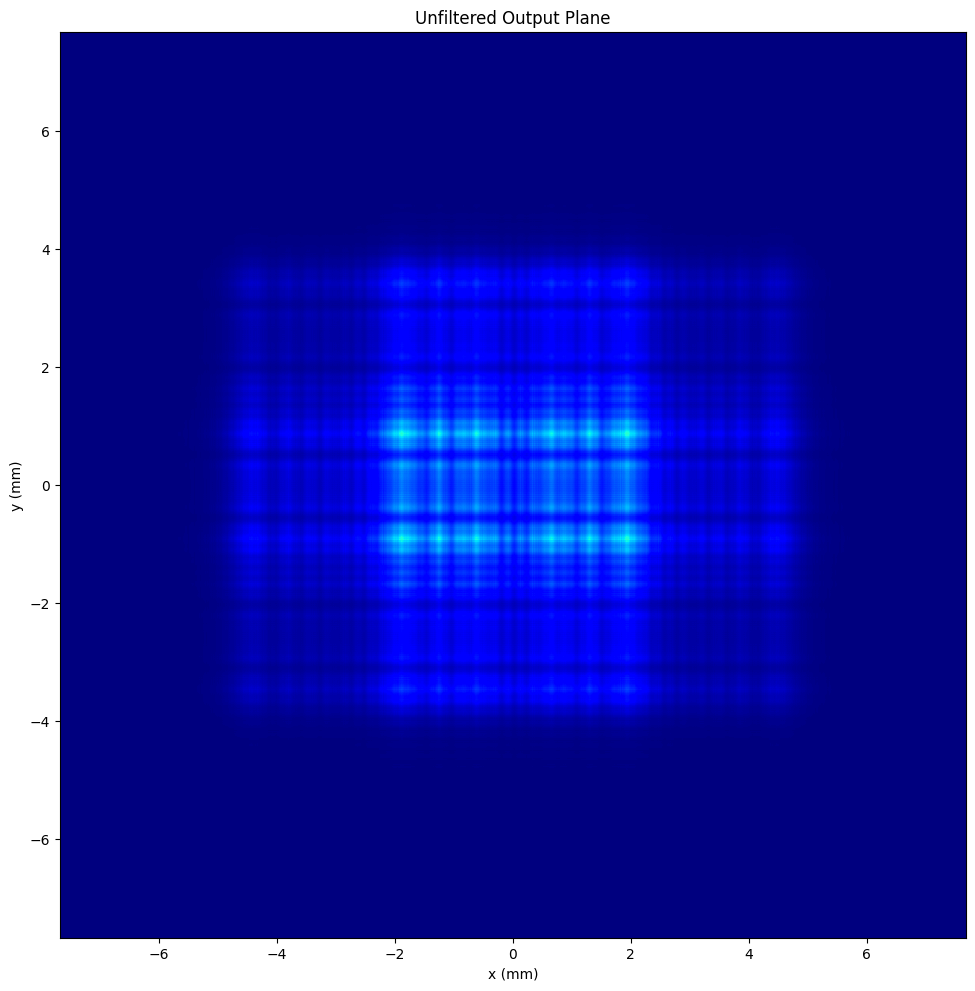

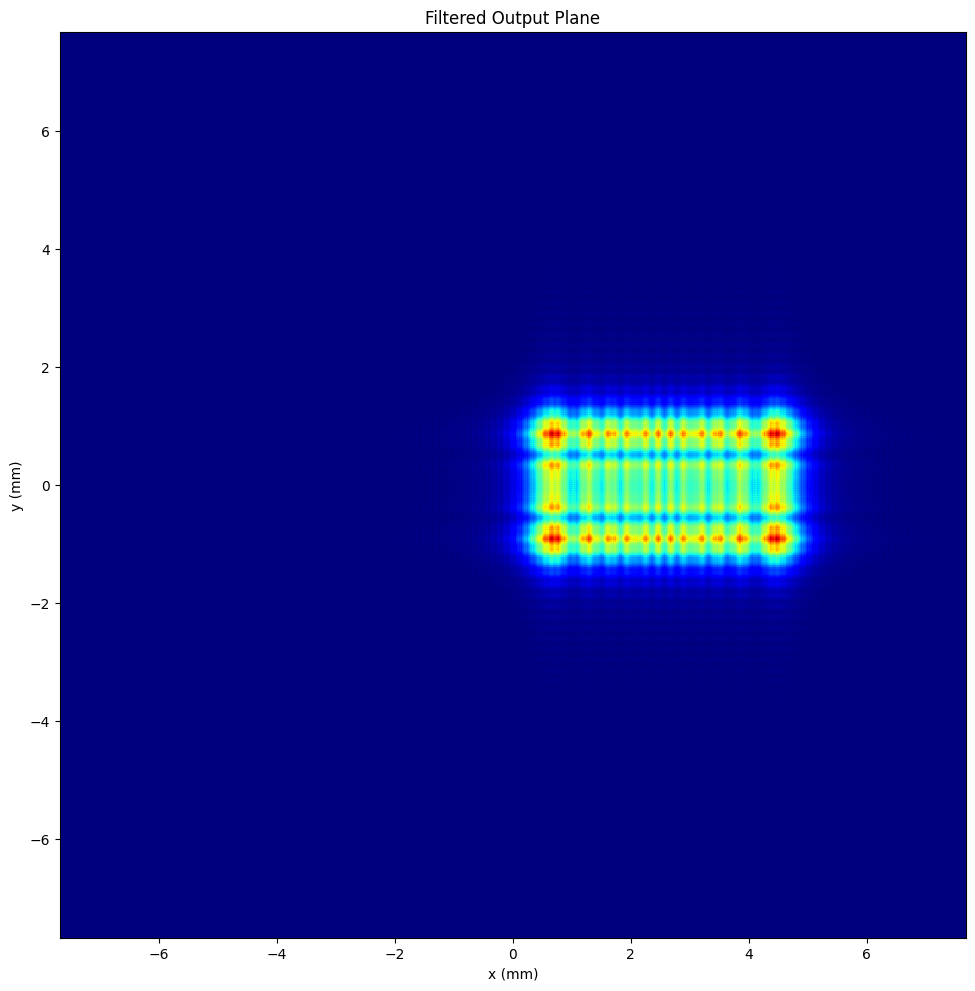

In [17]:
u3, L3x = Fraunhoffer_propagation(filtered_u2, L2x, lam, f)
u4, L4x = Fraunhoffer_propagation(u2, L2x, lam, f * 0.8)
I3 = np.abs(u3**2)
I4 = np.abs(u4**2)

plt.figure()
l3x_mm = L3x * 1e3
plt.imshow(I4, cmap="jet", extent=(-l3x_mm / 2, l3x_mm / 2, -l3x_mm / 2, l3x_mm / 2))
plt.title("Unfiltered Output Plane")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

plt.figure()
l3x_mm = L3x * 1e3
plt.imshow(I3, cmap="jet", extent=(-l3x_mm / 2, l3x_mm / 2, -l3x_mm / 2, l3x_mm / 2))
plt.title("Filtered Output Plane")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

